In [1]:
import pandas as pd
import os
import tqdm
from copy import deepcopy

In [2]:
original_udf= pd.read_csv('./data/user_data.csv')
original_pdf = pd.read_csv('./data/problem_data.csv')
original_idf_list = [pd.read_csv('./interaction_tmp/'+filename) for filename in os.listdir('./interaction_tmp/')]

# Problem Process

In [3]:
pdf = original_pdf.copy()

## 한국어/영어 문제 외 삭제

In [4]:
result = []
for index, info in pdf[['problemId','titles']].iterrows():
    pid, titles = info
    title_list = eval(titles)
    for j in title_list:
        language = j['language']
        if language=='ko' or language=='en':
            break
    else:
        result.append(pid)

In [5]:
pdf=pdf[pdf['problemId'].isin(result)==False]

In [6]:
pdf.shape

(23714, 15)

## isSolvble이 False인 문제 제거

In [7]:
pdf=pdf[pdf['isSolvable']==True]

In [8]:
pdf.shape

(23339, 15)

## level 20초과, unrated 문제 제거

In [9]:
pdf=pdf[(pdf['level']<21) & (pdf['level']>0)]

In [10]:
pdf.shape

(15416, 15)

## givesNorating

In [11]:
pdf=pdf[pdf['givesNoRating']==False]

In [12]:
pdf.shape

(15347, 15)

## tags

In [13]:
pdf=pdf[pdf['tags']!='[]']

In [14]:
pdf.shape

(14844, 15)

### 소분류 생성

In [15]:
tag = pd.DataFrame(columns=['tag_id','key','name'])
tag_set=set()
tag_problem=dict()
for i in pdf[['problemId','tags']].iterrows():
    tag_list=eval(i[1]['tags'])
    for j in tag_list:
        key = j['key']
        if key not in tag_problem:
            tag_problem[key]=set()
        tag_problem[key].add(i[1]['problemId'])
        if key in tag_set:
            continue
        tag_set.add(key)
        line = [len(tag_set),key]
        for k in j['displayNames']:
            if k['language']=='ko':
                line.append(k['name'])
                break
        tag = pd.concat([tag, pd.DataFrame(line, index=tag.columns, columns=[len(tag)]).T])

### 로그 기반 중분류 생성(소분류에서 선택)

In [16]:
log=[]
with open('./log.txt','r') as f:
    for line in f.read().replace('\n',' ').split('target : ')[1:]:
        if '(' in line:
            line = line[:line.find('(')]+line[line.find(')')+1:]
        else:
            line
        log.append(line)
log=list(map(lambda x : x.split(), log))
log=[line for line in log if line[-1]!='4']

In [17]:
# tmp = deepcopy(tag_problem)
for line in log:
    key = line[0]
    if key not in tag_problem:
        continue
    if len(line)>2:
        for key2 in line[2:-1]:
            tag_problem[key2] |= tag_problem[key]
    tag_problem.pop(key)    

### 대분류 생성(tag rule 적용)

In [18]:
middle_tag_problem = tag_problem
big_tag_problem=dict()
big_tag_problem['tree'] = middle_tag_problem['trees']

big_tag_problem['datastructure'] = middle_tag_problem['segtree'] 
big_tag_problem['datastructure'] |= middle_tag_problem['stack']
big_tag_problem['datastructure'] |= middle_tag_problem['priority_queue']
big_tag_problem['datastructure'] |= middle_tag_problem['queue']
big_tag_problem['datastructure'] |= middle_tag_problem['priority_queue']
big_tag_problem['datastructure'] |= middle_tag_problem['deque']
big_tag_problem['datastructure'] |= middle_tag_problem['disjoint_set']
big_tag_problem['datastructure'] |= middle_tag_problem['two_pointer']

big_tag_problem['graph'] = middle_tag_problem['graphs'] 
big_tag_problem['graph'] |= middle_tag_problem['bfs']
big_tag_problem['graph'] |= middle_tag_problem['dfs']

big_tag_problem['hash'] = middle_tag_problem['tree_set'] 
big_tag_problem['hash'] |= middle_tag_problem['hashing']

big_tag_problem['search'] = middle_tag_problem['binary_search']
big_tag_problem['search'] |= middle_tag_problem['ternary_search']
big_tag_problem['search'] |= middle_tag_problem['parametric_search']

big_tag_problem['dp'] = middle_tag_problem['dp']
big_tag_problem['greedy'] = middle_tag_problem['greedy']
big_tag_problem['math'] = middle_tag_problem['math']

big_tag_problem['bruteforce'] = middle_tag_problem['bruteforcing']
big_tag_problem['bruteforce'] |= middle_tag_problem['mitm']

big_tag_problem['recursion'] = middle_tag_problem['recursion']
big_tag_problem['recursion'] |= middle_tag_problem['divide_and_conquer']

big_tag_problem['basics'] = middle_tag_problem['sorting']
big_tag_problem['basics'] |= middle_tag_problem['implementation']
big_tag_problem['basics'] |= middle_tag_problem['string']

In [19]:
final_tag_df = tag[tag['key'].isin(middle_tag_problem.keys())]
final_tag_df['big_tag']=0

final_tag_df.loc[final_tag_df[final_tag_df['key']=='trees'].index,'big_tag']='tree'

final_tag_df.loc[final_tag_df[final_tag_df['key']=='segtree'].index,'big_tag']='datastructure'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='stack'].index,'big_tag']='datastructure'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='priority_queue'].index,'big_tag']='datastructure'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='queue'].index,'big_tag']='datastructure'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='priority_queue'].index,'big_tag']='datastructure'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='deque'].index,'big_tag']='datastructure'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='disjoint_set'].index,'big_tag']='datastructure'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='two_pointer'].index,'big_tag']='datastructure'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='graphs'].index,'big_tag']='graph'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='bfs'].index,'big_tag']='graph'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='dfs'].index,'big_tag']='graph'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='tree_set'].index,'big_tag']='hash'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='hashing'].index,'big_tag']='hash'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='binary_search'].index,'big_tag']='search'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='ternary_search'].index,'big_tag']='search'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='parametric_search'].index,'big_tag']='search'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='dp'].index,'big_tag']='dp'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='greedy'].index,'big_tag']='greedy'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='math'].index,'big_tag']='math'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='bruteforcing'].index,'big_tag']='bruteforce'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='mitm'].index,'big_tag']='bruteforce'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='recursion'].index,'big_tag']='recursion'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='divide_and_conquer'].index,'big_tag']='recursion'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='sorting'].index,'big_tag']='basics'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='implementation'].index,'big_tag']='basics'
final_tag_df.loc[final_tag_df[final_tag_df['key']=='string'].index,'big_tag']='basics'

/tmp/ipykernel_48/4046302140.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_tag_df['big_tag']=0


In [20]:
final_tag_df['tag_id']=range(len(final_tag_df))

/tmp/ipykernel_48/2801281359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_tag_df['tag_id']=range(len(final_tag_df))


In [21]:
final_tag_df=final_tag_df.reset_index().drop('index',axis=1)

In [22]:
final_tag_df.to_csv('./tag_ver2.csv',index=False)

### 분류된 tag에 없는 문제 제거

In [23]:
problem_set = eval('|'.join([str(i) for i in big_tag_problem.values()]))
pdf=pdf[pdf['problemId'].isin(problem_set)]

### problem의 중분류, 대분류 csv생성

In [24]:
tmp=pd.DataFrame()
for k,v in middle_tag_problem.items():
    for pid in v:
        tmp=pd.concat([tmp, pd.DataFrame([pid, k]).T])
tmp.columns=['problem_id','middle_tag']
tmp.sort_values('problem_id',inplace=True)
tmp.index=range(len(tmp))

In [25]:
problem_mtag = pd.get_dummies(tmp, columns=['middle_tag'],prefix_sep='',prefix='').groupby('problem_id').sum().reset_index()
problem_mtag.to_csv('./problem_mtag_ver1.csv',index=False)

In [26]:
tmp=pd.DataFrame()
for k,v in middle_tag_problem.items():
    for pid in v:
        tmp=pd.concat([tmp, pd.DataFrame([pid, k]).T])
tmp.columns=['problem_id','big_tag']
tmp.sort_values('problem_id',inplace=True)
tmp.index=range(len(tmp))

In [27]:
problem_mtag = pd.get_dummies(tmp, columns=['big_tag'],prefix_sep='',prefix='').groupby('problem_id').sum().reset_index()
problem_mtag.to_csv('./problem_btag_ver1.csv',index=False)

## column drop & rename

In [28]:
pdf.drop(['titleKo','titles','isSolvable','isPartial','givesNoRating'
              ,'isLevelLocked','official','tags','metadata'], inplace=True, axis=1)

In [29]:
pdf.rename(columns={
    "problemId":'problem_id','acceptedUserCount':'correct_users',
    'votedUserCount':'voted_users','averageTries':'average_tries'
},inplace=True)

# User & Interaction Process

## user

In [30]:
udf = original_udf

### 중복 유저 drop

In [31]:
udf = udf.drop_duplicates()

### 푼 문제가 없는 유저 삭제

In [32]:
udf=udf[udf['solvedCount']!=0]

### rating이 0인 유저 삭제

In [33]:
udf=udf[udf['rating']!=0]

### 관리자 제거

In [34]:
udf = udf[udf['proUntil']!='9999-12-31T00:00:00.000Z']

### User Column drop & rename

In [35]:
udf.drop(['bio', 'badgeId', 'backgroundId', 'profileImageUrl',
 'voteCount', 'class', 'classDecoration',
'tier', 'rating', 'ratingByProblemsSum',
'ratingByClass', 'ratingBySolvedCount', 'ratingByVoteCount',
'coins', 'stardusts', 'bannedUntil','proUntil',
'rank', 'isRival', 'isReverseRival'], inplace=True, axis=1)

In [36]:
udf.rename(columns={
"handle":'user_id','solvedCount':'solved_count',
'rivalCount':'follower_count','reverseRivalCount':'following_count',
'joinedAt':'joined_date','maxStreak':'max_streak'
},inplace=True)

## Interaction Process

In [37]:
idf= pd.concat(original_idf_list)

In [38]:
idf.shape

(12249255, 3)

In [39]:
idf.columns=['user_id','problem_id','answer_code']

### level 추가 및 problem data에 없는 문제 제거

In [40]:
idf = pd.merge(idf, pdf[['problem_id','level']], how='right')

In [41]:
idf = idf.sort_values(['user_id','level','problem_id','answer_code'])

In [42]:
idf.shape

(11916342, 4)

In [43]:
idf = idf.drop_duplicates(keep='last')

In [44]:
idf.dropna(inplace=True)

In [45]:
idf.shape

(11908064, 4)

## user 통일

In [46]:
user_list = set(idf['user_id'].unique()) & set(udf['user_id'].unique())

In [47]:
len(user_list)

75442

In [48]:
idf=idf[idf['user_id'].isin(user_list)]
udf=udf[udf['user_id'].isin(user_list)]

In [49]:
idf.to_csv('./data/interaction_ver2.csv',index=False)
udf.to_csv('./data/user_ver4.csv',index=False)

# middle_tag_rating

In [50]:
tmp = pd.merge(problem_mtag, pdf[['problem_id','level']])
for col in tmp.columns[1:-1]:
    tmp[col] *= tmp['level']**(0.9 +0.02*tmp['level'])

In [51]:
tmp=pd.merge(idf[idf['answer_code']==1], tmp, on='problem_id')

In [52]:
tmp.drop(['problem_id','answer_code','level_y','level_x'],inplace=True, axis=1)

Index(['bfs', 'binary_search', 'bruteforcing', 'deque', 'dfs', 'disjoint_set',
       'divide_and_conquer', 'dp', 'graphs', 'greedy', 'hashing',
       'implementation', 'math', 'mitm', 'parametric_search', 'priority_queue',
       'queue', 'recursion', 'segtree', 'sorting', 'stack', 'string',
       'ternary_search', 'tree_set', 'trees', 'two_pointer'],
      dtype='object')

In [53]:
def top(df, n=30):
    tag_list = [df[tag_name].sort_values(ascending=False)[:n].sum() for tag_name in problem_mtag.columns[1:]]
    return pd.DataFrame(tag_list,index=problem_mtag.columns[1:]).T

In [54]:
user_rating_middle = tmp.groupby('user_id').apply(top)

In [62]:
user_rating_middle=user_rating_middle.reset_index().drop('level_1',axis=1).set_index('user_id')

In [71]:
user_rating_middle.to_csv('./user_rating_middle_ver1.csv',index=False)

# big_tag_rating

In [65]:
user_rating_big=pd.DataFrame()

In [66]:
user_rating_big['tree'] = user_rating_middle['trees']

user_rating_big['datastructure'] = user_rating_middle['segtree'] 
user_rating_big['datastructure'] += user_rating_middle['stack']
user_rating_big['datastructure'] += user_rating_middle['priority_queue']
user_rating_big['datastructure'] += user_rating_middle['queue']
user_rating_big['datastructure'] += user_rating_middle['priority_queue']
user_rating_big['datastructure'] += user_rating_middle['deque']
user_rating_big['datastructure'] += user_rating_middle['disjoint_set']
user_rating_big['datastructure'] += user_rating_middle['two_pointer']

user_rating_big['graph'] = user_rating_middle['graphs'] 
user_rating_big['graph'] += user_rating_middle['bfs']
user_rating_big['graph'] += user_rating_middle['dfs']

user_rating_big['hash'] = user_rating_middle['tree_set'] 
user_rating_big['hash'] += user_rating_middle['hashing']

user_rating_big['search'] = user_rating_middle['binary_search']
user_rating_big['search'] += user_rating_middle['ternary_search']
user_rating_big['search'] += user_rating_middle['parametric_search']

user_rating_big['dp'] = user_rating_middle['dp']
user_rating_big['greedy'] = user_rating_middle['greedy']
user_rating_big['math'] = user_rating_middle['math']

user_rating_big['bruteforce'] = user_rating_middle['bruteforcing']
user_rating_big['bruteforce'] += user_rating_middle['mitm']

user_rating_big['recursion'] = user_rating_middle['recursion']
user_rating_big['recursion'] += user_rating_middle['divide_and_conquer']

user_rating_big['basics'] = user_rating_middle['sorting']
user_rating_big['basics'] += user_rating_middle['implementation']
user_rating_big['basics'] += user_rating_middle['string']

In [72]:
user_rating_big.to_csv('./user_rating_big_ver1.csv',index=False)

<AxesSubplot:>

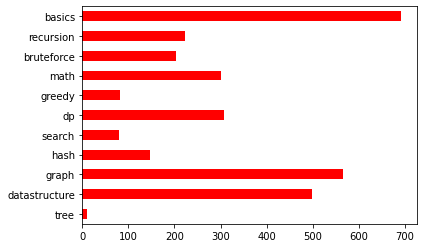

In [77]:
user_rating_big.loc['ghwns82'].plot(kind='barh',color='red')
# user_rating_big.loc['junhyuk1229'].plot(kind='bar',color='blue', alpha=0.5)

In [70]:
# user_rating_big.loc['kkj9818']